In [30]:
import os

os.environ["AZURE_OPENAI_API_KEY"] = os.getenv('Key_AzureOpenAI')
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv('Endpoint_AzureOpenAI')

In [31]:
from autogen_agentchat.agents import CodingAssistantAgent, ToolUseAssistantAgent
from autogen_agentchat.task import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_core.components.tools import FunctionTool

In [44]:
# testing 
from autogen_core.components.models import AzureOpenAIChatCompletionClient, UserMessage

azure_client = AzureOpenAIChatCompletionClient(
    model="gpt-4o",
    api_version="2024-02-01",
    model_capabilities={
        "vision":True,
        "function_calling":True,
        "json_output":True,
    }
)

In [33]:
model_client_result = await azure_client.create(
    messages=[
        UserMessage(content="What is the capital of France?", source="user"),
    ]
)
print(model_client_result)  # "Paris"

CreateResult(finish_reason='stop', content='The capital of France is Paris.', usage=RequestUsage(prompt_tokens=15, completion_tokens=7), cached=False, logprobs=None)


/var/folders/wp/6gm0gp7n5653wzt3d3527vsw0000gn/T/ipykernel_8536/3684532785.py:1: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-05-13. Model mapping may be incorrect.
  model_client_result = await azure_client.create(


In [61]:
import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from pytz import timezone  # type: ignore

def stock_news(ticker: str) -> list:
    """
    Get the most recent news of a stock or an instrument from Yahoo Finance

    Args:
    ticker (str): the stock ticker to be given to yfinance
    """
    stock = yf.Ticker(ticker)
    list_news = stock.news[0:2]
    return list_news


def analyze_stock(ticker: str) -> dict:  # type: ignore[type-arg]
    stock = yf.Ticker(ticker)

    # Get historical data (1 year of data to ensure we have enough for 200-day MA)
    end_date = datetime.now(timezone("UTC"))
    start_date = end_date - timedelta(days=365)
    hist = stock.history(start=start_date, end=end_date)

    # Ensure we have data
    if hist.empty:
        return {"error": "No historical data available for the specified ticker."}

    # Compute basic statistics and additional metrics
    current_price = stock.info.get("currentPrice", hist["Close"].iloc[-1])
    year_high = stock.info.get("fiftyTwoWeekHigh", hist["High"].max())
    year_low = stock.info.get("fiftyTwoWeekLow", hist["Low"].min())

    # Calculate 50-day and 200-day moving averages
    ma_50 = hist["Close"].rolling(window=50).mean().iloc[-1]
    ma_200 = hist["Close"].rolling(window=200).mean().iloc[-1]

    # Calculate YTD price change and percent change
    ytd_start = datetime(end_date.year, 1, 1, tzinfo=timezone("UTC"))
    ytd_data = hist.loc[ytd_start:]  # type: ignore[misc]
    if not ytd_data.empty:
        price_change = ytd_data["Close"].iloc[-1] - ytd_data["Close"].iloc[0]
        percent_change = (price_change / ytd_data["Close"].iloc[0]) * 100
    else:
        price_change = percent_change = np.nan

    # Determine trend
    if pd.notna(ma_50) and pd.notna(ma_200):
        if ma_50 > ma_200:
            trend = "Upward"
        elif ma_50 < ma_200:
            trend = "Downward"
        else:
            trend = "Neutral"
    else:
        trend = "Insufficient data for trend analysis"

    # Calculate volatility (standard deviation of daily returns)
    daily_returns = hist["Close"].pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252)  # Annualized volatility

    # Create result dictionary
    result = {
        "ticker": ticker,
        "current_price": current_price,
        "52_week_high": year_high,
        "52_week_low": year_low,
        "50_day_ma": ma_50,
        "200_day_ma": ma_200,
        "ytd_price_change": price_change,
        "ytd_percent_change": percent_change,
        "trend": trend,
        "volatility": volatility,
    }

    # Convert numpy types to Python native types for better JSON serialization
    for key, value in result.items():
        if isinstance(value, np.generic):
            result[key] = value.item()

    # Generate plot
    plt.figure(figsize=(12, 6))
    plt.plot(hist.index, hist["Close"], label="Close Price")
    plt.plot(hist.index, hist["Close"].rolling(window=50).mean(), label="50-day MA")
    plt.plot(hist.index, hist["Close"].rolling(window=200).mean(), label="200-day MA")
    plt.title(f"{ticker} Stock Price (Past Year)")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)

    # Save plot to file
    os.makedirs("coding", exist_ok=True)
    plot_file_path = f"coding/{ticker}_stockprice.png"
    plt.savefig(plot_file_path)
    print(f"Plot saved as {plot_file_path}")
    result["plot_file_path"] = plot_file_path

    return result

Plot saved as coding/AAPL_stockprice.png


{'ticker': 'AAPL',
 'current_price': 222.91,
 '52_week_high': 237.49,
 '52_week_low': 164.08,
 '50_day_ma': 227.1338003540039,
 '200_day_ma': 201.88410690307617,
 'ytd_price_change': 37.97178649902344,
 'ytd_percent_change': 20.532146941558537,
 'trend': 'Upward',
 'volatility': 0.22622808312989715,
 'plot_file_path': 'coding/AAPL_stockprice.png'}

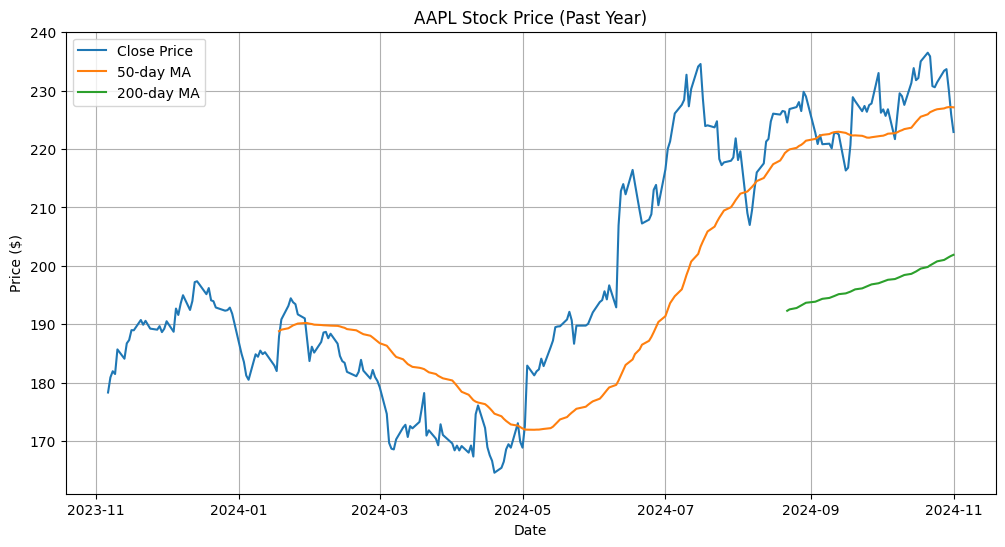

In [51]:
analyze_stock('AAPL')

In [62]:
stock_analysis_tool = FunctionTool(analyze_stock, description="Analyze stock data and generate a plot")
google_search_tool = FunctionTool(
    stock_news, description="Search Google for information, returns results with a snippet and body content"
)

In [63]:
search_agent = ToolUseAssistantAgent(
    name="News_Analyzs_Agent",
    model_client=azure_client,
    registered_tools=[google_search_tool],
    description="Get the most recent news of a stock or an instrument from Yahoo Finance",
    system_message="You are a helpful AI assistant. Solve tasks using your tools.",
)

stock_analysis_agent = ToolUseAssistantAgent(
    name="Stock_Analysis_Agent",
    model_client=azure_client,
    registered_tools=[stock_analysis_tool],
    description="Analyze stock data and generate a plot",
    system_message="You are a helpful AI assistant. Solve tasks using your tools.",
)

report_agent = CodingAssistantAgent(
    name="Report_Agent",
    model_client=azure_client,
    description="Generate a report based on the search and stock analysis results, which is easy to read in python environment",
    system_message="You are a helpful assistant that can generate a comprehensive report on a given topic based on search and stock analysis. When you done with generating the report, reply with TERMINATE.",
)

termination = TextMentionTermination("TERMINATE")
team = RoundRobinGroupChat([search_agent, stock_analysis_agent, report_agent], termination_condition=termination)

/var/folders/wp/6gm0gp7n5653wzt3d3527vsw0000gn/T/ipykernel_8536/4098346914.py:1: DeprecationWarning: ToolUseAssistantAgent is deprecated. Use AssistantAgent instead.
  search_agent = ToolUseAssistantAgent(
/var/folders/wp/6gm0gp7n5653wzt3d3527vsw0000gn/T/ipykernel_8536/4098346914.py:9: DeprecationWarning: ToolUseAssistantAgent is deprecated. Use AssistantAgent instead.
  stock_analysis_agent = ToolUseAssistantAgent(
/var/folders/wp/6gm0gp7n5653wzt3d3527vsw0000gn/T/ipykernel_8536/4098346914.py:17: DeprecationWarning: CodingAssistantAgent is deprecated. Use AssistantAgent instead.
  report_agent = CodingAssistantAgent(


/Users/michael/PycharmProjects/2024BarclaysHackathonNew/.venv/lib/python3.10/site-packages/autogen_agentchat/agents/_assistant_agent.py:299: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-05-13. Model mapping may be incorrect.
  result = await self._model_client.create(
/Users/michael/PycharmProjects/2024BarclaysHackathonNew/.venv/lib/python3.10/site-packages/autogen_agentchat/agents/_assistant_agent.py:258: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-05-13. Model mapping may be incorrect.
  result = await self._model_client.create(


TaskResult(messages=[TextMessage(source='user', model_usage=None, content='Write a financial report on American airlines'), ToolCallMessage(source='News_Analyzs_Agent', model_usage=RequestUsage(prompt_tokens=79, completion_tokens=31), content=[FunctionCall(id='call_xluepZVy268gZWpxne8joeai', arguments='{"ticker": "AAL"}', name='stock_news')]), ToolCallResultMessage(source='News_Analyzs_Agent', model_usage=None, content=[FunctionExecutionResult(content="[{'uuid': '7cad5834-fed2-3f52-956f-05775cb7f7c7', 'title': 'New DOT rule requires airlines to refund travelers for flight delays', 'publisher': 'Yahoo Finance Video', 'link': 'https://finance.yahoo.com/video/dot-rule-requires-airlines-refund-171500384.html', 'providerPublishTime': 1730481300, 'type': 'VIDEO', 'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/ZtqJ.Tt7qRgVYusd9Hya2A--~B/aD00NTA0O3c9ODAwMDthcHBpZD15dGFjaHlvbg--/https://s.yimg.com/os/creatr-uploaded-images/2024-11/2d647430-986d-11ef-8df6-90bebb417170',

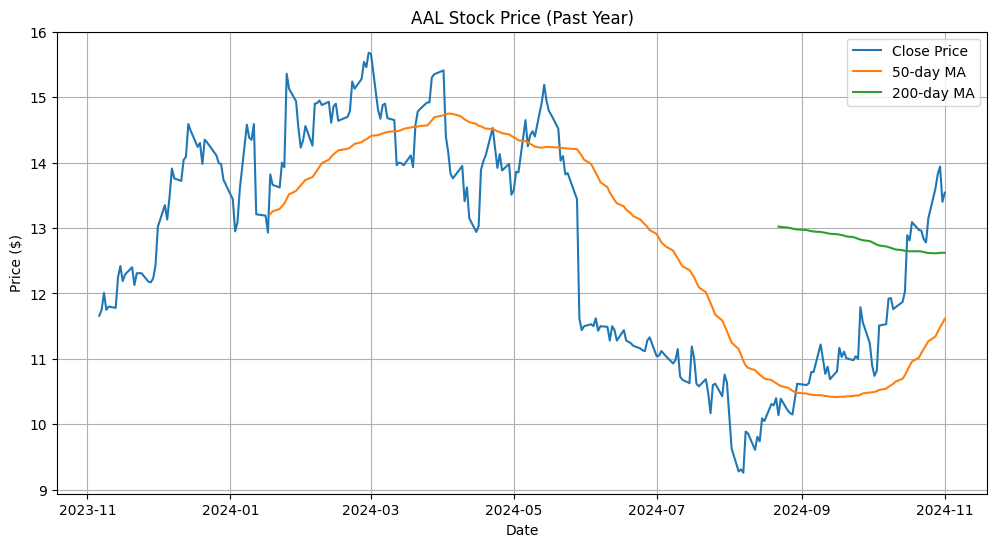

In [64]:
result = await team.run("Write a financial report on American airlines")
print(result)

In [73]:
for i in range(len(result.messages)):
    print(result.messages[i])
    print('________________________')

source='user' model_usage=None content='Write a financial report on American airlines'
________________________
source='News_Analyzs_Agent' model_usage=RequestUsage(prompt_tokens=79, completion_tokens=31) content=[FunctionCall(id='call_xluepZVy268gZWpxne8joeai', arguments='{"ticker": "AAL"}', name='stock_news')]
________________________
source='News_Analyzs_Agent' model_usage=None content=[FunctionExecutionResult(content="[{'uuid': '7cad5834-fed2-3f52-956f-05775cb7f7c7', 'title': 'New DOT rule requires airlines to refund travelers for flight delays', 'publisher': 'Yahoo Finance Video', 'link': 'https://finance.yahoo.com/video/dot-rule-requires-airlines-refund-171500384.html', 'providerPublishTime': 1730481300, 'type': 'VIDEO', 'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/ZtqJ.Tt7qRgVYusd9Hya2A--~B/aD00NTA0O3c9ODAwMDthcHBpZD15dGFjaHlvbg--/https://s.yimg.com/os/creatr-uploaded-images/2024-11/2d647430-986d-11ef-8df6-90bebb417170', 'width': 8000, 'height': 4504,

In [74]:
print(result.messages[-1].content)

### Financial Report on American Airlines Group Inc. (Ticker: AAL)

#### Recent News Highlights:
1. **New DOT Rule Requires Airlines to Refund Travelers for Flight Delays**
   - **Publisher:** Yahoo Finance Video
   - **Summary:** The U.S. Department of Transportation (DOT) has introduced a new rule that mandates airlines to refund travelers for significant flight delays. This may impact American Airlines (AAL) and other major carriers by increasing the financial responsibility associated with operational inefficiencies.
   - **Link:** [Watch Video](https://finance.yahoo.com/video/dot-rule-requires-airlines-refund-171500384.html)

2. **American Airlines to Offer More Flights to Italy in 2025**
   - **Publisher:** MT Newswires
   - **Summary:** American Airlines has announced plans to expand its flight offerings to Italy starting in 2025. This strategic move aims to capture a larger share of the transatlantic travel market and boost international revenue.
   - **Link:** [Read More](http